Les datas sur lesquels ont été effecté cette analyse ont été récupéré via https://data.stackexchange.com/stackoverflow/query/new avec la requete suivante sur des périodes de 6 mois du 01/2019 au 12/2023
  
&nbsp;&nbsp;SELECT TOP(50000)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Id,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CreationDate,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Score,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ViewCount,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;AnswerCount,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CommentCount,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FavoriteCount,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Title,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Body,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tags  
&nbsp;&nbsp;FROM Posts  
&nbsp;&nbsp;WHERE 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CreationDate BETWEEN CONVERT(datetime, '2020-01-01') AND CONVERT(datetime, '2020-06-30')  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 4  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;AND Score > 0  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;AND ViewCount IS NOT NULL  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;AND AnswerCount IS NOT NULL   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;AND FavoriteCount IS NOT NULL  
&nbsp;&nbsp;ORDER BY Score DESC  

NB : suite a des soucis d'antivirus (détection de phishing) la période de 01/2020->06/2020 n'a pas pu être récupéré

In [49]:
from bs4 import BeautifulSoup
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import IPython.display
import os
import warnings
warnings.filterwarnings('ignore')

In [50]:
data = pd.DataFrame()
dir_path='./data_for_exploration_all/'
for idx, file in enumerate(os.listdir(dir_path)):
    path = dir_path + file
    df = pd.read_csv(path,
                     index_col=0,
                     parse_dates=['CreationDate'],
                     na_values='NaN'
                     )
    print(idx, "-   fichier: ", file, "-   Nombre d'individus: ", len(df))
    data = pd.concat([data, df],
                     axis=0)

print('\n')
print(f"Nombre d'individus total : {data.shape[0]}")
print('\n')
# na_body_idx = data[data['Body'].isna()==True].index
# data.drop(index = na_body_idx, inplace=True)
data.sort_values('CreationDate', inplace=True)
display(data.head())

0 -   fichier:  data-2019-01_to_2019-06.csv -   Nombre d'individus:  42329
1 -   fichier:  data-2019-07_to_2019-12.csv -   Nombre d'individus:  38379
2 -   fichier:  data-2020-07_to_2020-12.csv -   Nombre d'individus:  30417
3 -   fichier:  data-2021-01_to_2021-06.csv -   Nombre d'individus:  24453
4 -   fichier:  data-2021-07_to_2021-12.csv -   Nombre d'individus:  18047
5 -   fichier:  data-2022-01_to_2022-06.csv -   Nombre d'individus:  14590
6 -   fichier:  data-2022-07_to_2022-12.csv -   Nombre d'individus:  4943
7 -   fichier:  data-2023-01_to_2023-06.csv -   Nombre d'individus:  4


Nombre d'individus total : 173162




,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
Id,,,,,,,,,
53992317,2019-01-01 00:26:29,17,10664,5,0,0,How to set size/rotate image in jekyll?,<p>How to set size of image in jekyll markdown...,<html><markdown><jekyll><github-pages>
53992339,2019-01-01 00:34:20,1,973,1,1,0,Error converting data type nvarchar to numeric...,<p>I have a project that is written using <cod...,<php><sql-server><laravel><eloquent><laravel-5.7>
53992438,2019-01-01 01:08:58,5,3247,3,0,0,Is it possible to convert a markdown file with...,<p>Is there a way of converting a markdown fil...,<html><markdown><atom-editor><pandoc>
53992595,2019-01-01 01:57:15,1,145,1,0,0,WriteConsoleOutput wrong spacing,<p>Why are the characters written in 1 cell? T...,<c#><console><console-application><windows-con...
53992606,2019-01-01 02:01:14,11,10913,2,0,0,Plotly - different color surfaces,"<p>I'm trying to plot several surfaces, each o...",<python><python-3.x><jupyter-notebook><plotly>


In [51]:
def getCompletion(data):
    """
    Calcule le pourcentage de complétion et le nombre de valeurs manquantes pour chaque colonne d'un DataFrame.

    Args:
        data (pd.DataFrame): Le DataFrame pour lequel calculer ces statistiques.

    Returns:
        pd.DataFrame: Un DataFrame contenant le pourcentage de complétion et le nombre de valeurs manquantes 
                      pour chaque colonne du DataFrame d'entrée.
    """
    res = ((len(data) - data.isnull().sum())*100/len(data)).to_frame()
    res['count missing'] = data.isnull().sum().to_frame()
    res = res.rename(columns={0: 'completion'})
    return res

In [52]:
stats = getCompletion(data)
print(stats)

               completion  count missing
CreationDate        100.0              0
Score               100.0              0
ViewCount           100.0              0
AnswerCount         100.0              0
CommentCount        100.0              0
FavoriteCount       100.0              0
Title               100.0              0
Body                100.0              0
Tags                100.0              0


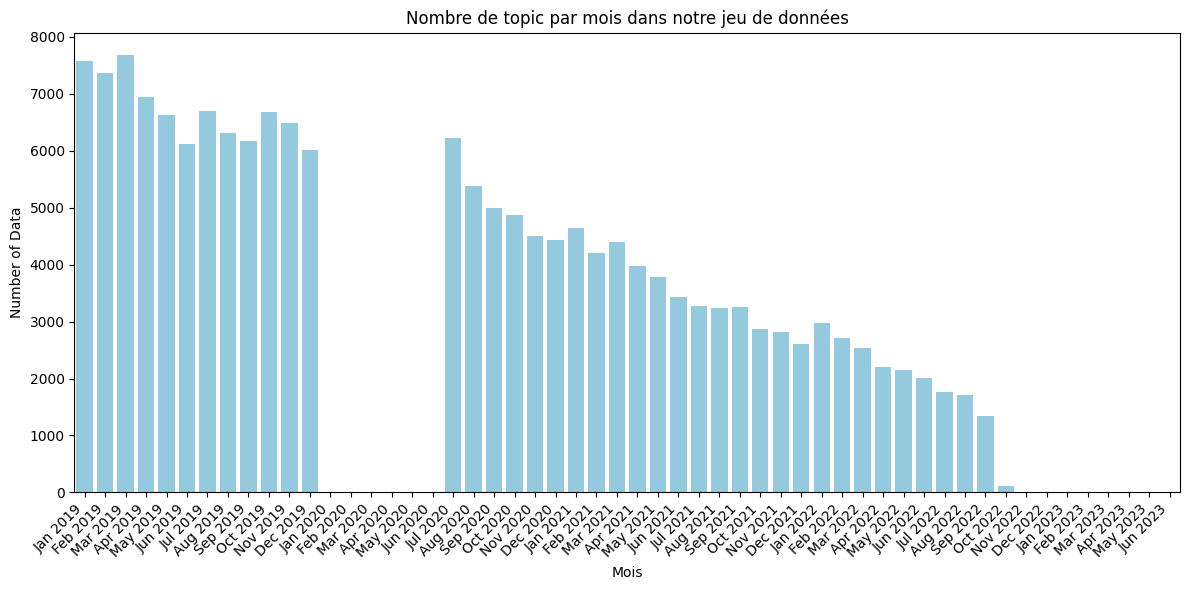

In [53]:
date_range = pd.date_range(start='2019-01-01', end='2023-06-30', freq='M')
monthly_data = pd.DataFrame(index=date_range)
monthly_counts = data.resample('M', on='CreationDate').size()
monthly_data['Number of Data'] = monthly_counts

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_data.index.strftime('%b %Y'),
            y='Number of Data', data=monthly_data, color='skyblue')
plt.title('Nombre de topic par mois dans notre jeu de données')
plt.xlabel('Mois')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

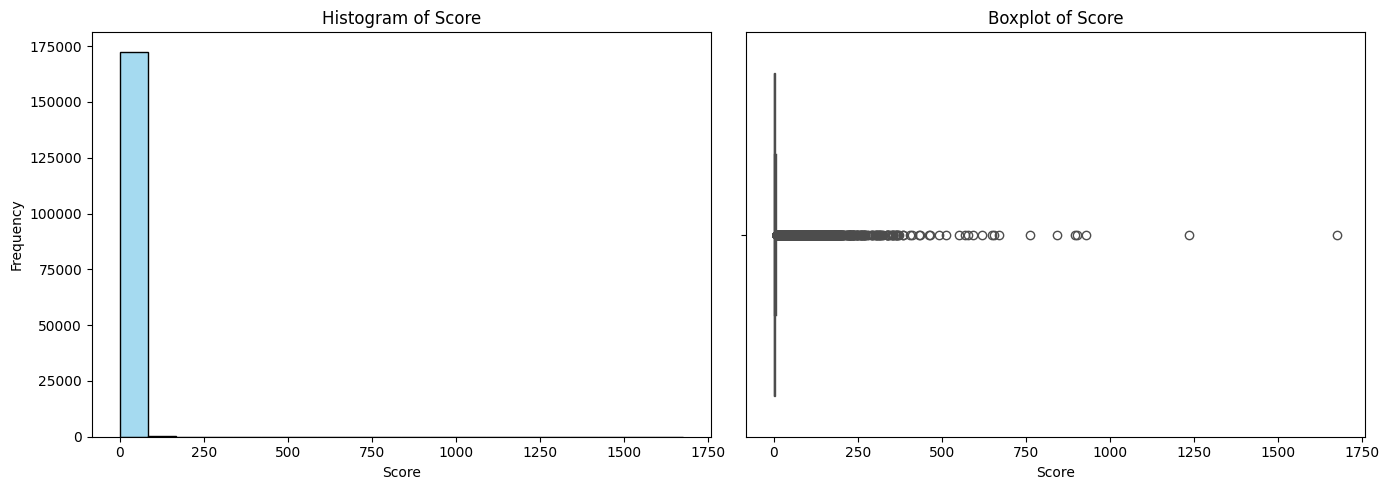

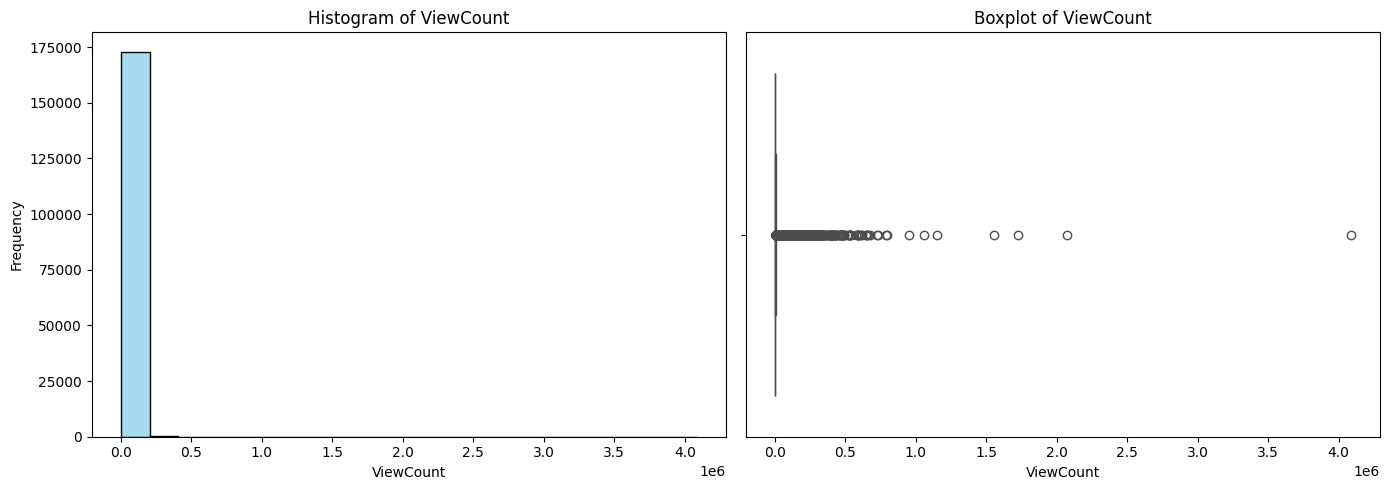

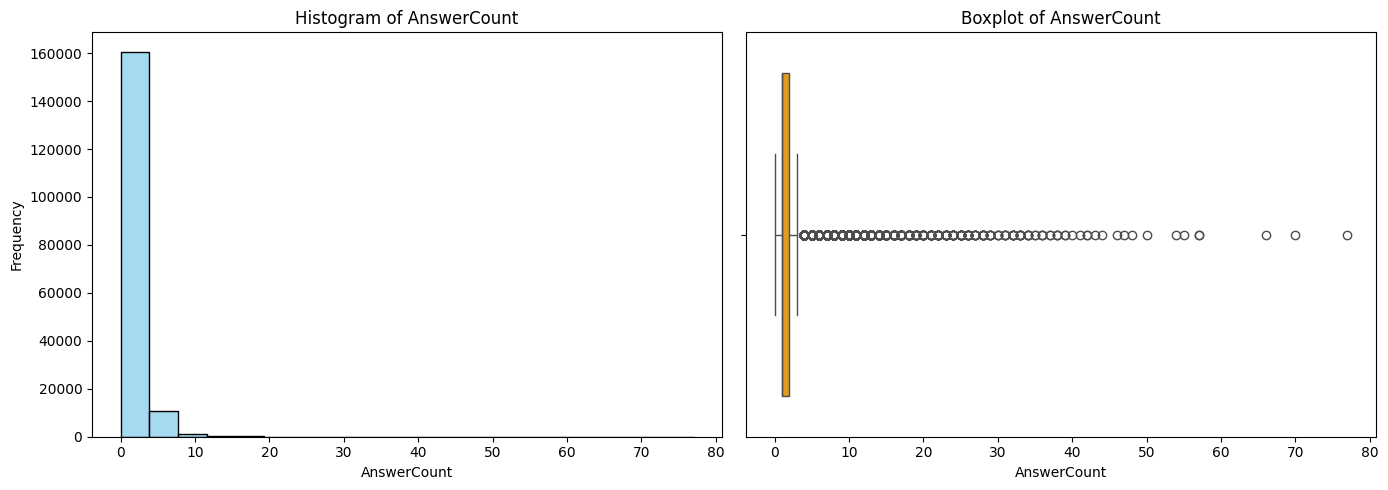

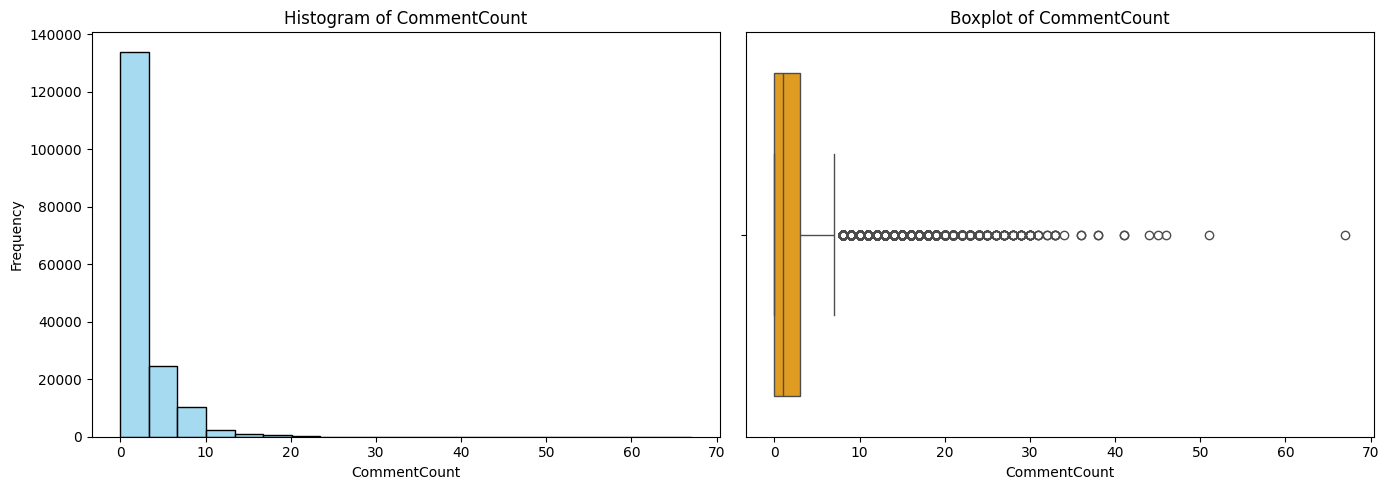

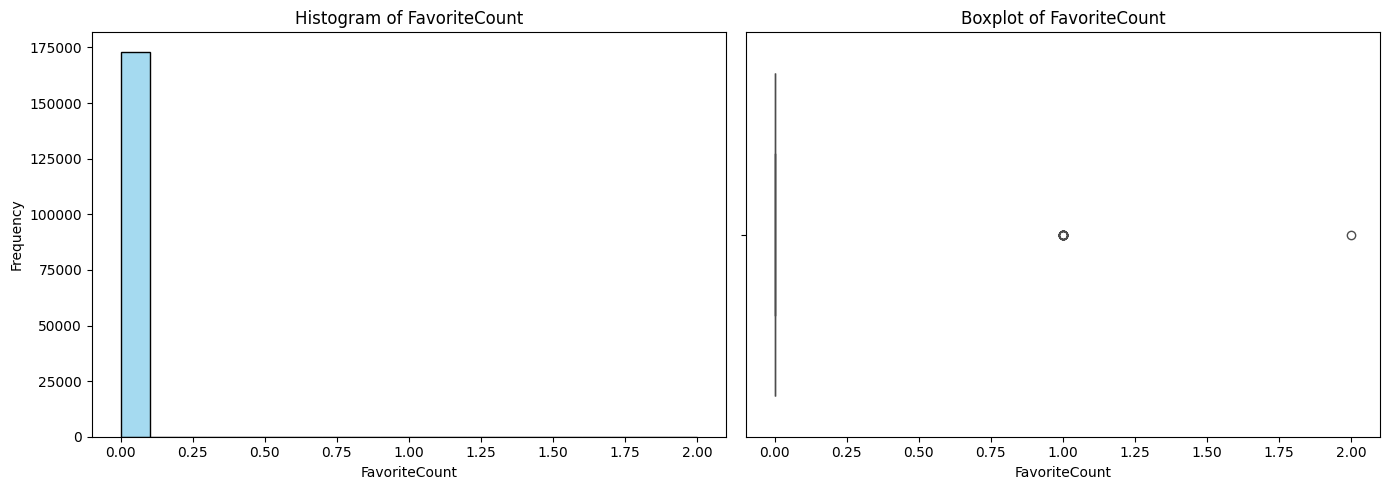

In [54]:
quantitative_columns = ['Score', 'ViewCount',
                        'AnswerCount', 'CommentCount', 'FavoriteCount']
for column in quantitative_columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot histogram on the first subplot
    sns.histplot(data[column], bins=20, kde=False, color='skyblue', ax=axes[0])
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Histogram of {column}')

    # Plot boxplot on the second subplot
    sns.boxplot(x=data[column], ax=axes[1], color='orange')
    axes[1].set_xlabel(column)
    axes[1].set_title(f'Boxplot of {column}')

    # Adjust the layout
    plt.tight_layout()

    # Display the plots
    plt.show()

In [55]:
valeur = pd.DataFrame(data['Tags'])

In [56]:
print(valeur['Tags'][0:1])

Id
53992317    <html><markdown><jekyll><github-pages>
Name: Tags, dtype: object


In [57]:
df = pd.DataFrame(data['Tags'])

In [58]:
# Fonction pour extraire les champs entre < et >
def extract_tags(tag_string):
    """
    Extract all the html balises in a string

    Args:
        tag_string (str): string to look into
        
    Returns:
        list: all HTML balises found.
    """
    return re.findall(r'<(.*?)>', tag_string)


# Appliquer la fonction à la colonne 'Tags' et créer une liste de tous les tags
all_tags = df['Tags'].apply(extract_tags).explode().tolist()

            tag  count
0        python  29739
1    javascript  21468
2          java  15287
3       android  11452
4       reactjs  10056
..          ...    ...
95  react-hooks    994
96        regex    984
97        flask    967
98  woocommerce    967
99        dplyr    953

[100 rows x 2 columns]


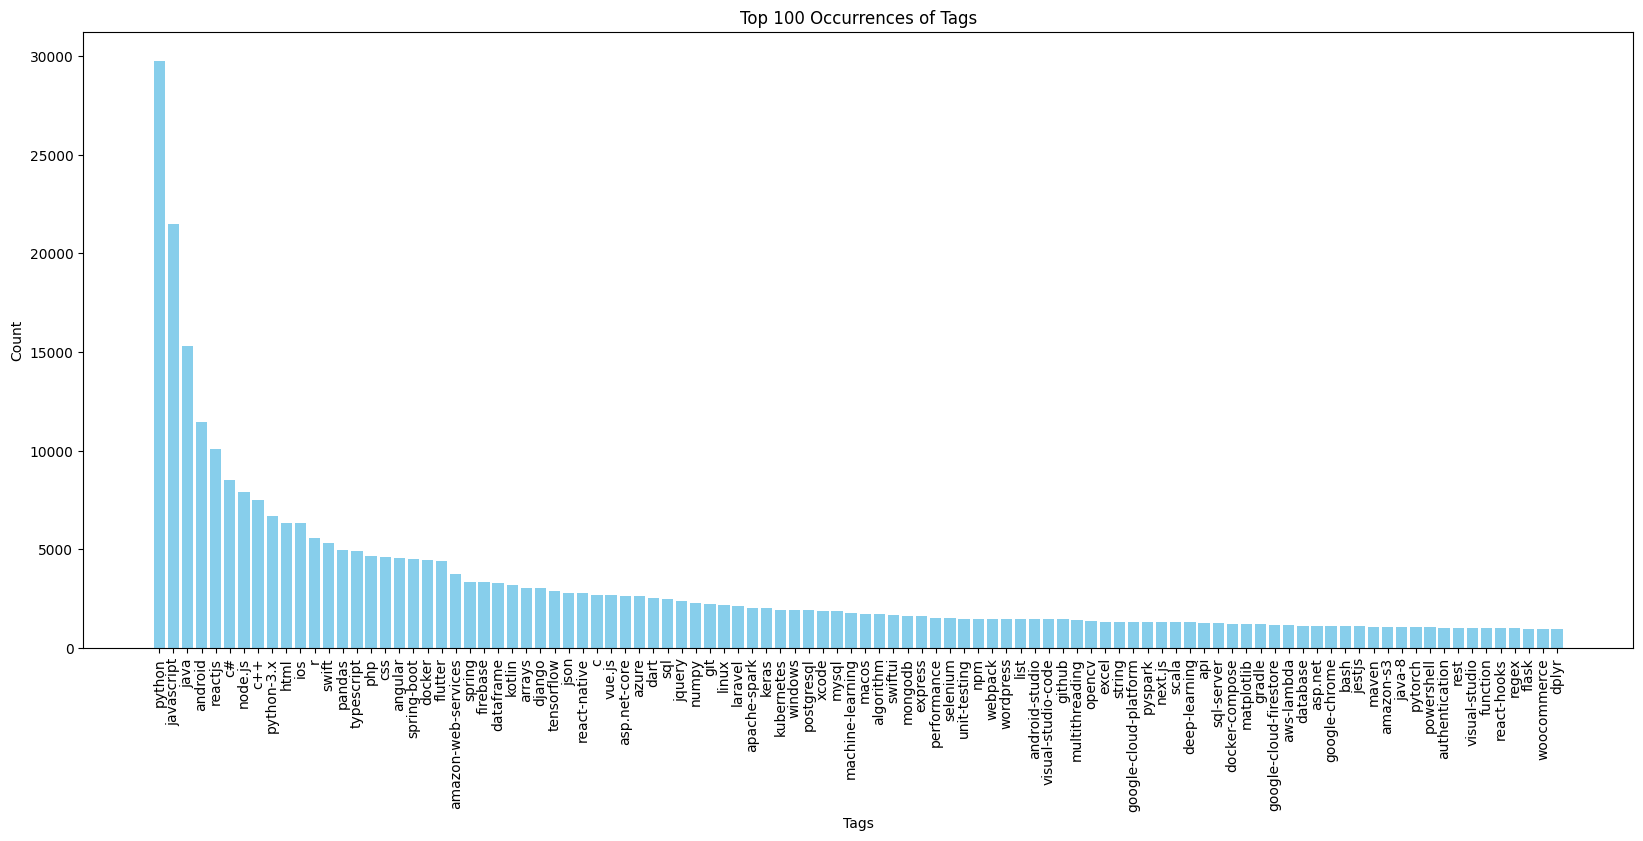

In [59]:
# Compter les occurrences de chaque tag
tag_counts = Counter(all_tags)

# Sélectionner les 100 tags les plus représentés
top_100_tags = dict(
    sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:100])

# Créer un DataFrame pour les 100 tags les plus représentés
top_100_tags_df = pd.DataFrame.from_dict(
    top_100_tags, orient='index', columns=['count']).reset_index()
top_100_tags_df = top_100_tags_df.rename(columns={'index': 'tag'})

# Afficher le DataFrame des 100 tags les plus représentés
print(top_100_tags_df)

# Créer un histogramme des 100 tags les plus représentés
plt.figure(figsize=(20, 8))
plt.bar(top_100_tags_df['tag'], top_100_tags_df['count'], color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.title('Top 100 Occurrences of Tags')
plt.xticks(rotation=90)
plt.show()

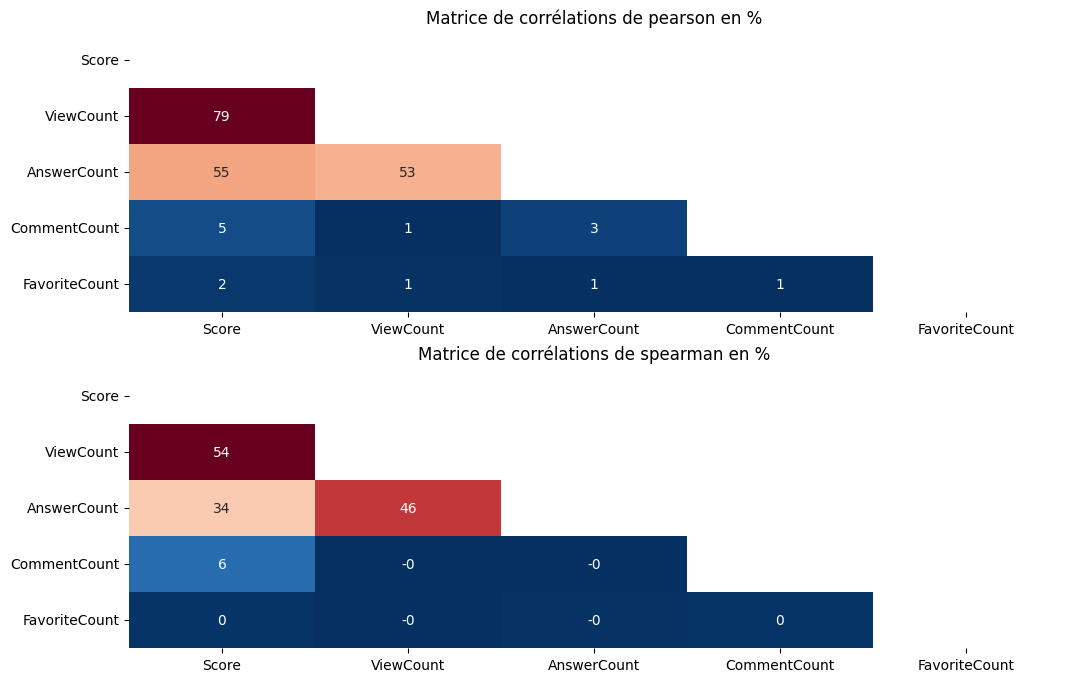

In [60]:
def correlations(data, methods=["pearson", "spearman"]):
    """
    Display the correlations matrixes defined by the methods

    Args:
        data (DataFrame): datraframe containing the datas.
        methods (list, optional): Methods used to define the matrixes (default =pearson & spearman).

    Returns:
        None
    """
    correlations = []
    cleanning_masks = []
    for method in methods:
        correlation = data.select_dtypes(
            include=['int64', 'float64']).corr(method=method) * 100
        cleanning_mask = np.zeros_like(correlation)
        upper_triangle = np.triu_indices_from(correlation)
        cleanning_mask[upper_triangle] = 1
        correlations.append(correlation)
        cleanning_masks.append(cleanning_mask)

    fig, axes = plt.subplots(nrows=len(methods), figsize=(12, 8))
    fig.subplots_adjust(wspace=0.2)

    for i in range(len(axes)):
        sns.heatmap(correlations[i], ax=axes[i], cmap="RdBu_r", mask=cleanning_masks[i],
                    annot=True, fmt=".0f", cbar=False)

        axes[i].set_title(f"Matrice de corrélations de {methods[i]} en %")


correlations(data)

# Analyse/normalisation des titre et body

In [61]:
import pandas as pd
from collections import Counter
import re


# Combiner les textes des colonnes 'title' et 'body'
combined_texts = data['Title'] + ' ' + data['Body']

# Tokenizer le texte combiné pour obtenir les mots individuels


def tokenize(text):
    '''
    Transfor a text to a list of words

    Parameters:
    - text (string): text to tokenize.

    Returns:
    - list: tonized text.
    '''
    # Enlever la ponctuation et convertir le texte en minuscules
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()


# Appliquer la tokenization sur chaque texte combiné
all_words = []
for text in combined_texts:
    all_words.extend(tokenize(text))

# Compter les occurrences de chaque mot unique
word_counts = Counter(all_words)

# Afficher les résultats
# print(word_counts)

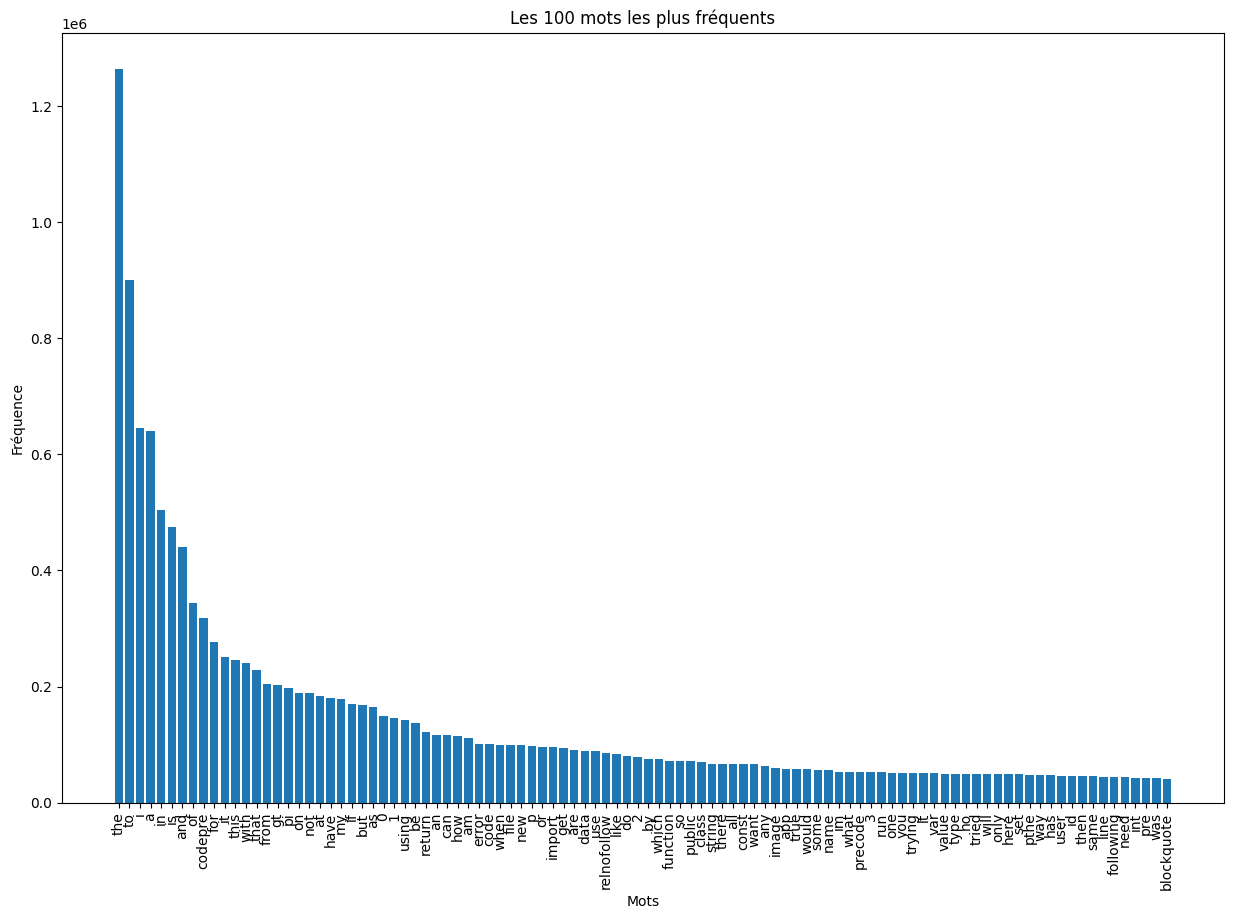

In [62]:
# Récupérer les 100 mots les plus fréquents
most_common_words = word_counts.most_common(100)
# Séparer les mots et leurs fréquences pour l'affichage
words, occurrences = zip(*most_common_words)
# Créer l'histogramme
plt.figure(figsize=(15, 10))
plt.bar(words, occurrences)
plt.xticks(rotation=90)
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.title('Les 100 mots les plus fréquents')
plt.show()

In [63]:
# TO DO ONCE TO DL stopwords
# import nltk
# nltk.download('stopwords')

In [64]:
# Charger les stopwords en anglais
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Tokenizer le texte combiné pour obtenir les mots individuels


def tokenize_apply_stopWords_stemmer(text):
    '''
    Transfor a text to a list of words and remove words uysing english stemmer

    Parameters:
    - text (string): text to tokenize.

    Returns:
    - list: cleaned text.
    '''
    # Enlever la ponctuation et convertir le texte en minuscules
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Diviser le texte en mots et filtrer les stopwords
    words = [word for word in text.split() if word not in stop_words]
    # Appliquer le stemming
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words


def tokenize_apply_stopWords(text):
    '''
    Transfor a text to a list of words

    Parameters:
    - text (string): text to tokenize.

    Returns:
    - list: cleaned text.
    '''
    # Enlever la ponctuation et convertir le texte en minuscules
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Diviser le texte en mots et filtrer les stopwords
    words = [word for word in text.split() if word not in stop_words]
    # Appliquer le stemming
    return words

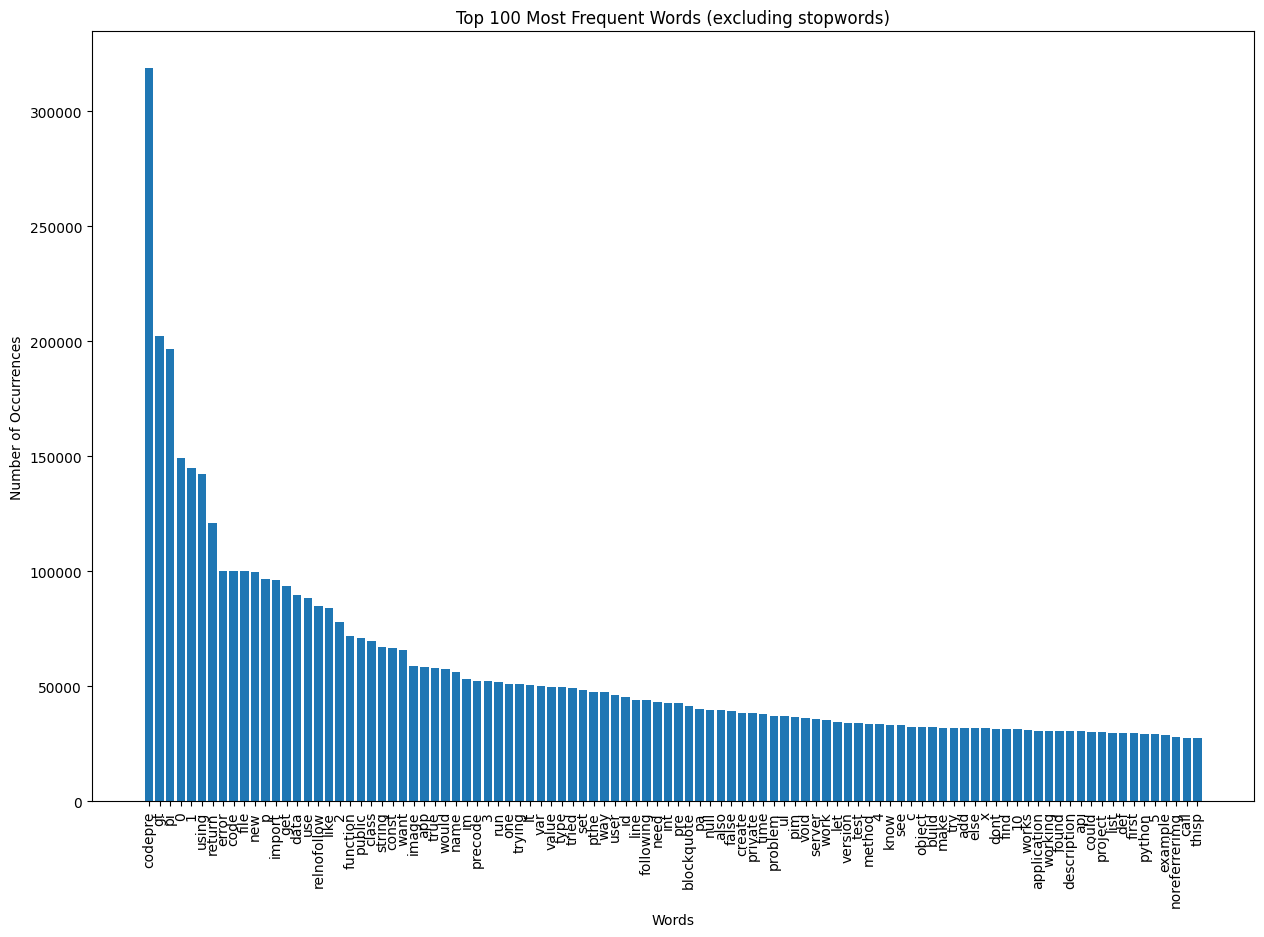

In [65]:
all_words_stopWords = []
for text in combined_texts:
    all_words_stopWords.extend(tokenize_apply_stopWords(text))

# Compter les occurrences de chaque mot unique
word_counts = Counter(all_words_stopWords)

# Récupérer les 100 mots les plus fréquents
most_common_words = word_counts.most_common(100)

# Séparer les mots et leurs occurrences pour l'affichage
words, occurrences = zip(*most_common_words)

# Créer l'histogramme
plt.figure(figsize=(15, 10))
plt.bar(words, occurrences)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Number of Occurrences')
plt.title('Top 100 Most Frequent Words (excluding stopwords)')
plt.show()

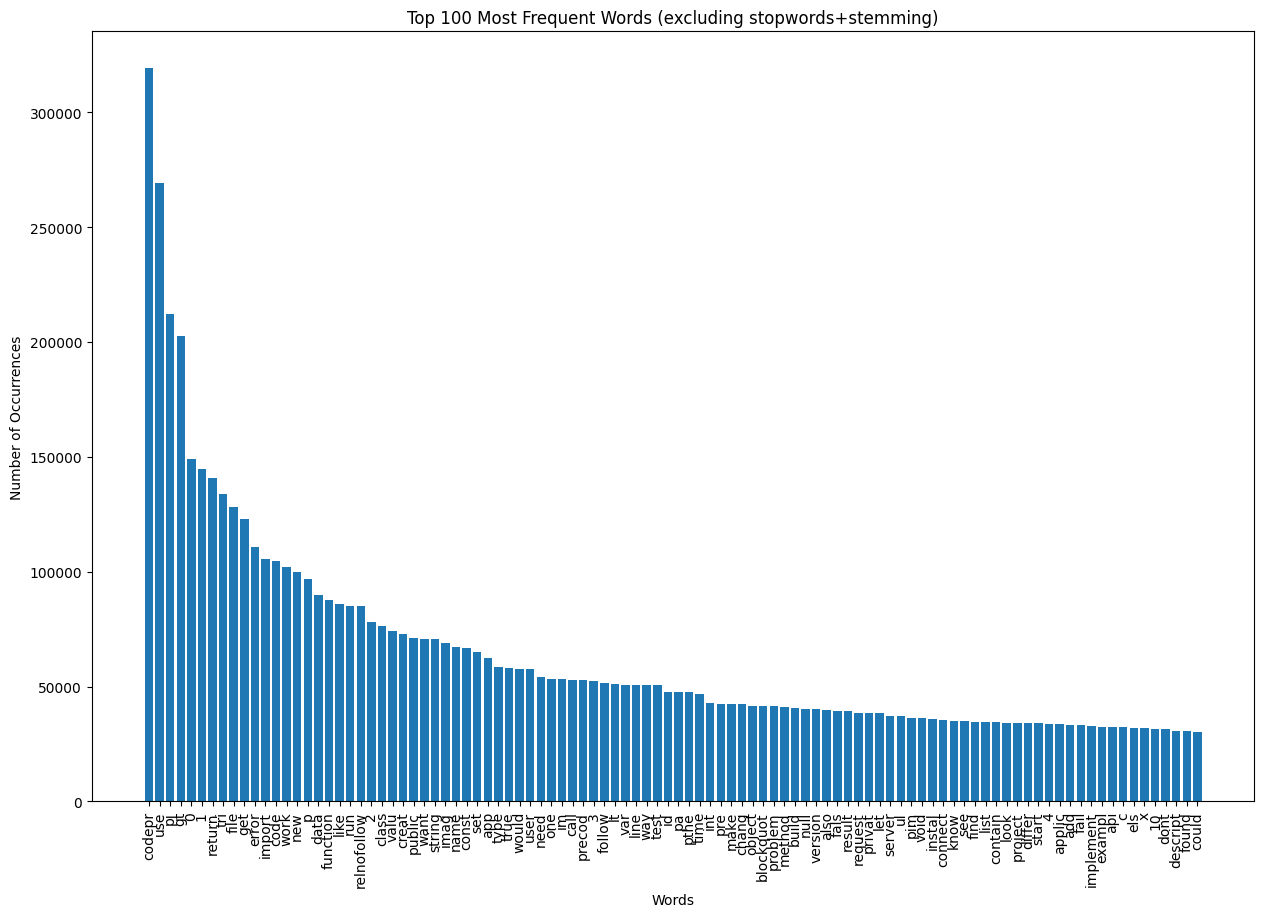

In [66]:
all_words_stopWords = []
for text in combined_texts:
    all_words_stopWords.extend(tokenize_apply_stopWords_stemmer(text))

# Compter les occurrences de chaque mot unique
word_counts = Counter(all_words_stopWords)

# Récupérer les 100 mots les plus fréquents
most_common_words = word_counts.most_common(100)

# Séparer les mots et leurs occurrences pour l'affichage
words, occurrences = zip(*most_common_words)

# Créer l'histogramme
plt.figure(figsize=(15, 10))
plt.bar(words, occurrences)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Number of Occurrences')
plt.title('Top 100 Most Frequent Words (excluding stopwords+stemming)')
plt.show()

Notre analyse s'est porté sur l'ensemble title+body qu'il semblerait pertinent de rassembler dans une variable que l'on pourrait nommer post  
On remarque aussi la forte représentation de string courte qui pourrait sembler parasite (tel que des chiffres ou des fragments de code)  
  
La décision a donc été prise de procéder a un nettoyage plus poussé avant d'aller plus loin

# From Title & Body TO Post

Afin de définir les tags, il semble plus pertinent de considérer titre et body ensemble plutot que séparemment.  
Nous allons donc appliquer le traitement tokenize + stem +idf

In [67]:
data['Post'] = data.apply(lambda x: x['Title'] + ' ' + x['Body'], axis=1)
corpus = data['Post'].to_list()
tags = data['Tags'].to_list()

In [68]:
for i in range(2):
    print(i, " : ", corpus[i])
    print('-------------------------------------------- \nl')

0  :  How to set size/rotate image in jekyll? <p>How to set size of image in jekyll markdown?</p>

<pre><code>![steam-fish-1]({{ "/assets/steam-fish-1.jpeg" | absolute_url }})
</code></pre>

<p>I'm using jekyll minima. Using </p>

<pre><code>![steam-fish-1]({{ "/assets/steam-fish-1.jpeg" | absolute_url }} =250x)
</code></pre>

<p>from <a href="https://stackoverflow.com/questions/14675913/changing-image-size-in-markdown">Changing image size in Markdown</a> doesn't work. If possible, I would like to know how to rotate image as well. </p>

-------------------------------------------- 
l
1  :  Error converting data type nvarchar to numeric when trying to create a record using Eloquent <p>I have a project that is written using <code>PHP</code> on the top of <a href="https://laravel.com/" rel="nofollow noreferrer">Laravel 5.7</a> framework. I am using <a href="https://laravel.com/docs/5.7/eloquent" rel="nofollow noreferrer">Eloquent ORM</a> to interact with my SQL Server. </p>

<p>I am tryin

## Nettoyage

### Retrait des reliquats d'html due a la requete sql

In [69]:
def remove_html_tags(text):
    '''
    Use BeautifulSoup to remove html tags

    Parameters:
    - text (string): text to clean.

    Returns:
    - str: cleaned text.
    '''
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [70]:
data['Body'] = data['Body'].apply(remove_html_tags)
data['Post'] = data['Post'].apply(remove_html_tags)

### Cleaning avancé (en se basant sur le traitement lors de notre précédente analyse)

On constate dans notre analyse précédente que de nombreuses chaine de char courtes sont souvent présentes (certainement due a des morceaux de code dans les posts)  
Il a donc été décidé de retirer les strings de longueur <= 3 (for, if, i ...), cependant cette décision risque de retirer le nom de certains langages de programmation  
Afin d'éviter cela on va mettre en place une liste de petits mots autorisé (basé sur l'analyse précédente)

In [71]:
def clean_text(text, small_text_autorized=[""]):
    '''
    Clean a given text by removing newlines, ponctuation, small words and suppression uppercase

    Parameters:
    - text (string): text to clean.
    - small_text_autorized (list, optional): list of small texte that will stay.

    Returns:
    - str: cleaned text.
    '''
    text = re.sub(r'\n', ' ', text)
    result = re.sub(r'[^\w\s]', '', text.lower())


    result = result.split(" ")

    result = list(filter(lambda x: len(
        x) > 3 or x in small_text_autorized, result))

    return " ".join(result)

In [72]:
autorized = ["c", "cpp", "c++", "c#", "qt", "js", "url",
             "web", "app", "api", "run", "r", "css", "sql", "git"]

In [73]:
data['Title'] = data['Title'].apply(lambda x: clean_text(x, autorized))
data['Body'] = data['Body'].apply(lambda x: clean_text(x, autorized))
data['Post'] = data['Post'].apply(lambda x: clean_text(x, autorized))

error,converting,data,type,nvarchar,numeric,when,trying,create,record,using,eloquent,have,project,that,written,using,laravel,framework,using,eloquent,interact,with,server,trying,user,modelinsert,modelcreate,eloquent,model,create,either,single,record,bulk,record,however,keep,getting,this,sqlserver,error,sqlstate42000,microsoftodbc,driver,serversql,servererror,converting,data,type,nvarchar,numeric,insert,into,table_name,i,understand,what,issue,sure,what,column,causing,problem,is,possible,query,that,eloquent,generating,what,columns,causing,problem,is,there,better,approach,figure,cause,this,problem,my,database,columns,that,arent,strings,tried,defining,them,casts,property,eloquent,model,like,so,protected,casts,bathrooms,float,bedrooms,float,matrixid,int,integrationid,int,price,float,but,still,getting,same,error,i,also,tried,install,laraveldebugbar,does,insert,query,perhaps,because,error,query,does,logged,how,figure,problem

### Tokenisation + stemming

In [74]:
data['Title'] = data['Title'].apply(
    lambda x: tokenize_apply_stopWords_stemmer(x))
data['Body'] = data['Body'].apply(
    lambda x: tokenize_apply_stopWords_stemmer(x))
data['Post'] = data['Post'].apply(
    lambda x: tokenize_apply_stopWords_stemmer(x))

### Prevent empty cases

Notre traitement peut causer des title vide  
  
En cas de title ou body vide on retirera l'individu de notre corpus

In [75]:
print(len(data))
data = data[data['Title'].map(len) > 0]
print(len(data))
data = data[data['Body'].map(len) > 0]
print(len(data))
data = data[data['Post'].map(len) > 0]
print(len(data))

173162
173157
173157
173154


# Bag of words

In [76]:
data_bag = pd.DataFrame(data[['Title','Tags']])
data_bag['Tags'] = data_bag['Tags'].apply(extract_tags)
data_bag['Combined'] = data_bag['Title'].apply(lambda x: ' '.join(x)) + ' ' + data_bag['Tags'].apply(lambda x: ' '.join(x))
data_bag['Title'] = data_bag['Title'].apply(lambda x: ' '.join(x))
data_bag['Tags'] = data_bag['Tags'].apply(lambda x: ' '.join(x))


In [77]:
data_bag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173154 entries, 53992317 to 75905798
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Title     173154 non-null  object
 1   Tags      173154 non-null  object
 2   Combined  173154 non-null  object
dtypes: object(3)
memory usage: 5.3+ MB


In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

top = 100

vectorizer_title = TfidfVectorizer()
X_title = vectorizer_title.fit_transform(data_bag['Title'])

vectorizer_tags = TfidfVectorizer()
X_tags = vectorizer_tags.fit_transform(data_bag['Tags'])

# Obtenir les mots les plus fréquents pour les titres
words_title = vectorizer_title.get_feature_names_out()
sum_tfidf_title = X_title.sum(axis=0)
words_freq_title = [(word, sum_tfidf_title[0, idx]) for word, idx in vectorizer_title.vocabulary_.items()]
words_freq_title = sorted(words_freq_title, key=lambda x: x[1], reverse=True)[:top]

# Obtenir les mots les plus fréquents pour les tags
words_tags = vectorizer_tags.get_feature_names_out()
sum_tfidf_tags = X_tags.sum(axis=0)
words_freq_tags = [(word, sum_tfidf_tags[0, idx]) for word, idx in vectorizer_tags.vocabulary_.items()]
words_freq_tags = sorted(words_freq_tags, key=lambda x: x[1], reverse=True)[:top]

# Extraire les mots les plus fréquents
top_words_title = [word for word, _ in words_freq_title]
top_words_tags = [word for word, _ in words_freq_tags]

In [79]:
# Créer un vecteur TF-IDF pour les top mots les plus fréquents pour les titres
vectorizer_title = TfidfVectorizer(vocabulary=top_words_title)
X_title = vectorizer_title.fit_transform(data_bag['Title'])

# Créer un vecteur TF-IDF pour les top mots les plus fréquents pour les tags
vectorizer_tags = TfidfVectorizer(vocabulary=top_words_tags)
X_tags = vectorizer_tags.fit_transform(data_bag['Tags'])

In [80]:
import scipy.sparse as sp

# Combiner les deux matrices
X_combined = sp.hstack([X_title, X_tags])

# Convertir en DataFrame pour visualisation
combined_df = pd.DataFrame(X_combined.toarray(), columns=top_words_title + top_words_tags)

In [81]:
df_bow_title = pd.DataFrame(X_title.toarray(), columns=top_words_title)
df_bow_tags = pd.DataFrame(X_tags.toarray(), columns=top_words_tags)

In [82]:
data_bag.to_csv("data_bag.csv")
df_bow_title.to_csv("df_bow_title.csv")
df_bow_tags.to_csv("df_bow_tags.csv")

             Dim1       Dim2
0       -1.802230 -34.839088
1        6.902393 -31.844126
2        3.123977 -40.844749
3       29.174500  37.437981
4       75.017906   4.815836
...           ...        ...
173149 -23.003780  39.766468
173150 -10.242348 -35.216831
173151 -34.158596 -31.044834
173152 -40.156338 -36.383675
173153 -32.437511 -21.981668

[173154 rows x 2 columns]


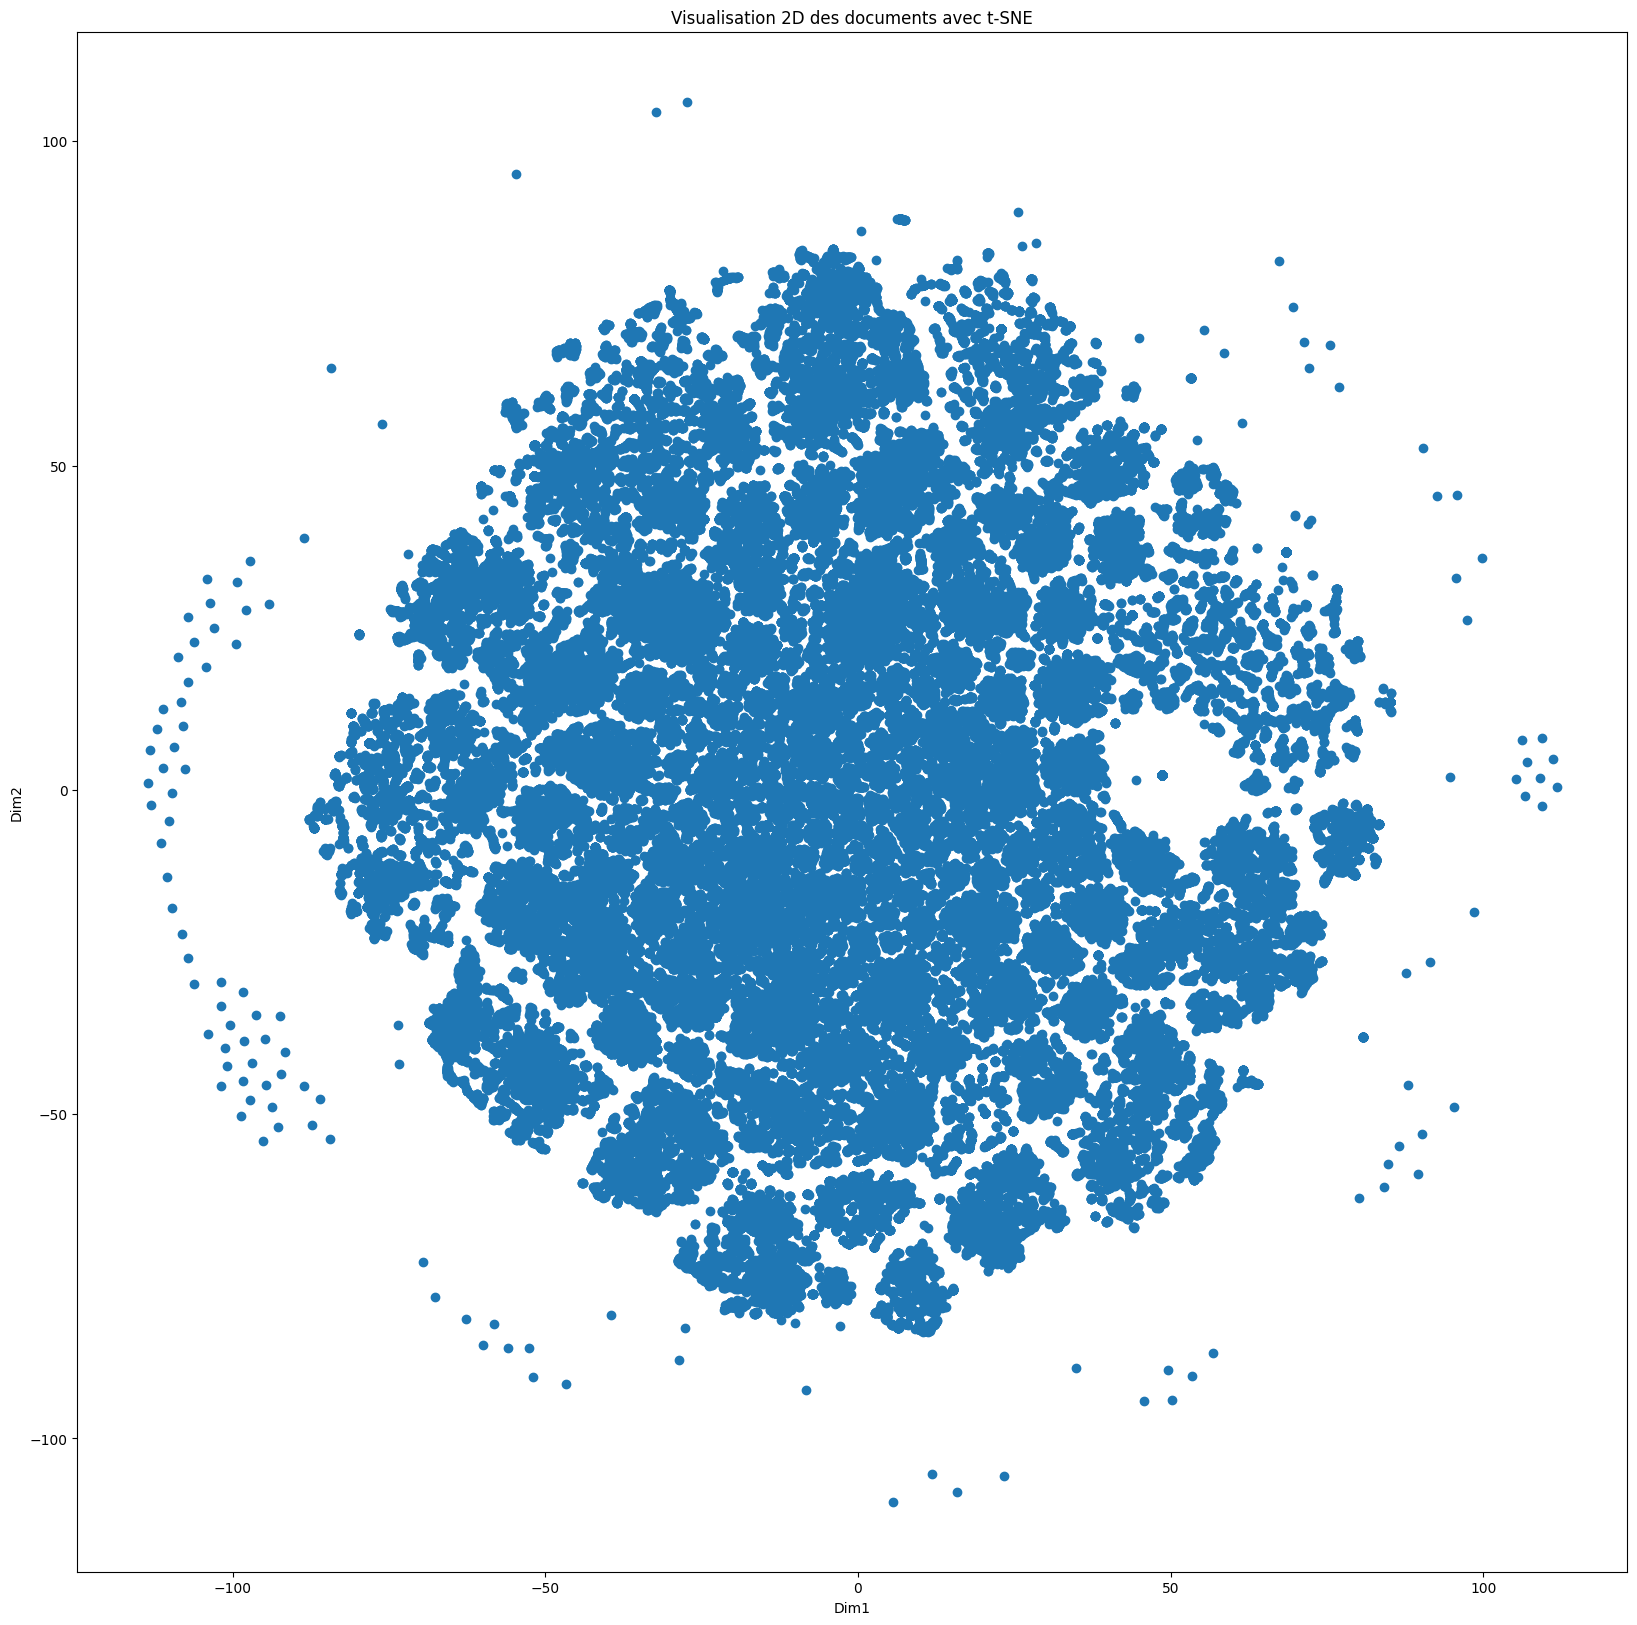

In [83]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimension à 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(combined_df.values)

# Convertir la matrice t-SNE en DataFrame pour une meilleure visualisation
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])

# Afficher le DataFrame t-SNE
print(tsne_df)

# Visualiser les documents dans l'espace 2D
plt.figure(figsize=(20, 20))
plt.scatter(tsne_df['Dim1'], tsne_df['Dim2'])
for i, txt in enumerate(data_bag.index):
    plt.annotate('', (tsne_df['Dim1'][i], tsne_df['Dim2'][i]))
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('Visualisation 2D des documents avec t-SNE')
plt.show()